## Expert Knowledge Worker

### A question answering agent that is an expert knowledge worker
### To be used by employees of Insurellm, an Insurance Tech company
### The agent needs to be accurate and the solution should be low cost.

This project will use RAG (Retrieval Augmented Generation) to ensure our question/answering assistant has high accuracy.

This first implementation will use a simple, brute-force type of RAG..

In [3]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr

In [4]:
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import plotly.graph_objects as go
from langchain_community.embeddings import HuggingFaceEmbeddings


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/likhs/projects/llm_engineering/venv311/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/likhs/projects/llm_engineering/venv311/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/likhs/projects/llm_engineering/venv311/lib/python3.11/site-packages/ipykernel/kernelapp

In [23]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_openai import ChatOpenAI

In [24]:
# Use a low cost model since cost is equally important

MODEL = "gpt-4o-mini"
db_name = "vector_db"

In [25]:
# Load environment variables in a file called .env

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [26]:
# Read in documents using LangChain's loaders
# Load all the information from our knowledge-base folder

folders = glob.glob("knowledge-base-bank/*")

def add_metadata(doc, doc_type):
    doc.metadata["doc_type"] = doc_type
    return doc
text_loader_kwargs = {'encoding': 'utf-8'}

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    documents.extend([add_metadata(doc, doc_type) for doc in folder_docs])

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

print(f"Total number of chunks: {len(chunks)}")
print(f"Document types found: {set(doc.metadata['doc_type'] for doc in documents)}")

Total number of chunks: 25
Document types found: {'services', 'employees', 'company', 'contracts'}


In [27]:
# Put the chunks of data into a Vector Store that associates a Vector Embedding with each chunk
# Chroma is a popular open source Vector Database based on SQLLite

embeddings = OpenAIEmbeddings()
if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

# Create vectorstore

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 25 documents


In [28]:
# Let's investigate the vectors

collection = vectorstore._collection 
count = collection.count()

sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"There are {count:,} vectors with {dimensions:,} dimensions in the vector store")

There are 25 vectors with 1,536 dimensions in the vector store


## Visualizing the Vector Store

Let's take a minute to look at the documents and their embedding vectors to see what's going on.

In [29]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
metadatas = result['metadatas']
doc_types = [metadata['doc_type'] for metadata in metadatas]
colors = [['blue', 'green', 'red', 'orange'][['company', 'services', 'employees', 'contracts'].index(t)] for t in doc_types]

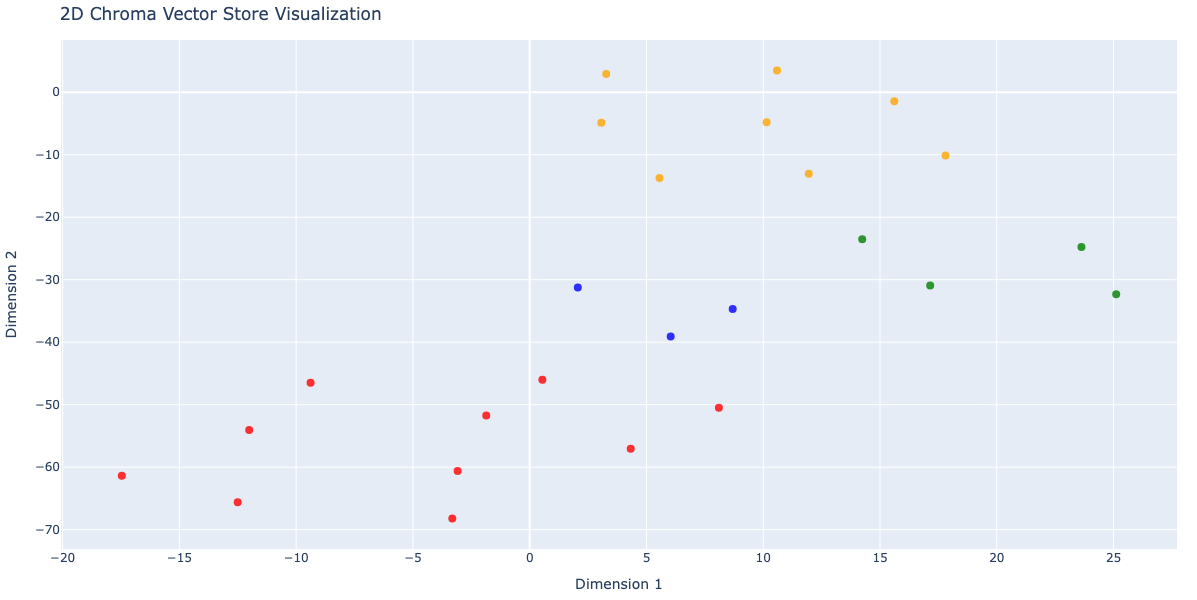

In [31]:
# Visualize a 2-D structure of your chroma vector datastore containing your documents using a tSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10) 
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=8, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Chroma Vector Store Visualization',
    xaxis_title='Dimension 1',
    yaxis_title='Dimension 2',
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

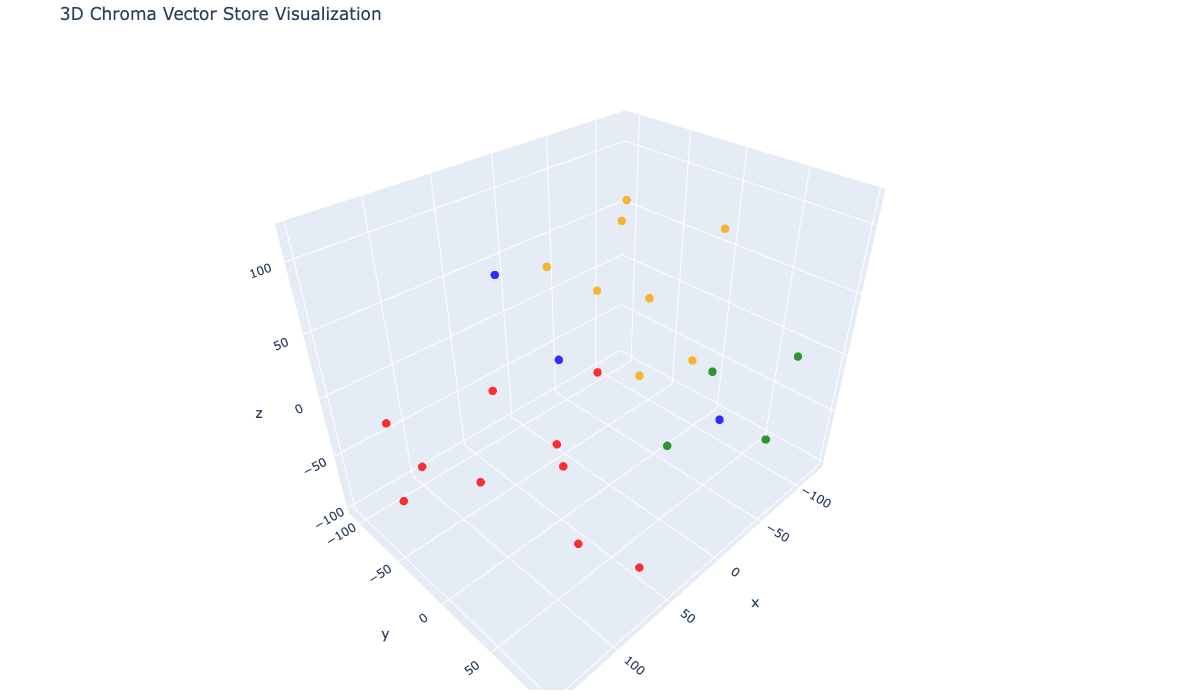

In [33]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42, perplexity=10)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

## Time to use LangChain to bring it all together

In [38]:
# Create a new Chat with OpenAI
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

# Set up the retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 4})

# Create the prompt template with memory
prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful assistant answering questions about a company. 
    Use the following context to answer the question. If you don't know the answer, say so.
    
    Context: {context}"""),
    MessagesPlaceholder(variable_name="chat_history"),
    ("human", "{question}")
])

In [39]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Create the prompt template
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant. Answer the question based on the following context:\n\n{context}"),
    MessagesPlaceholder(variable_name="chat_history", optional=True),
    ("human", "{question}")
])

# Build the chain properly
conversational_chain = (
    {
        "context": itemgetter("question") | retriever | format_docs,
        "question": itemgetter("question"),
        "chat_history": itemgetter("chat_history")
    }
    | prompt
    | llm
    | StrOutputParser()
)



Answer: The provided context does not include any information about a service called Insurella. Therefore, I cannot explain what Insurella is based on the current data. If you have additional information or context about Insurella, please provide it, and I would be happy to help!


In [40]:
# Let's try asking it a simple question
query = "Please talk about the ceo of your bank"
result = conversational_chain.invoke({
    "question": query,
    "chat_history": []  # Empty list for first question
})

print(f"\nAnswer: {result}")


Answer: The CEO of Finovia Bank is Laura Singh. She founded the bank in 2012 and has been leading it since its inception. Under her leadership, Finovia has grown into a significant player in the fintech industry, focusing on innovation and partnerships to drive the company's global expansion. 

Laura's vision for Finovia Bank is to redefine customer banking through transparency and accessibility. She aims to make finance simple and empowering for individuals and small businesses. With over 8 million customers across 15 countries, Finovia has become a trusted name in digital banking.

Laura is known for her commitment to innovation, steering the bank's flagship services, which include DigitalBanking, SmartLend, SecureVault, and InvestIQ. Her leadership has been pivotal in establishing Finovia's mission to democratize access to modern banking. 

Laura joined Finovia in 2012 and is based in the New York office, where she continues to drive the bank's strategic direction and growth.


## Now we will bring this up in Gradio using the Chat interface -

A quick and easy way to prototype a chat with an LLM

In [45]:
from langchain_core.messages import HumanMessage, AIMessage

def chat(question, history):
    """Chat function for Gradio interface"""
    # Convert Gradio history to LangChain message format
    chat_history = []
    for msg in history:
        if msg["role"] == "user":
            chat_history.append(HumanMessage(content=msg["content"]))
        else:
            chat_history.append(AIMessage(content=msg["content"]))
    
    # Invoke chain with proper format
    result = conversational_chain.invoke({
        "question": question,
        "chat_history": chat_history
    })
    return result

In [47]:
# Create and launch Gradio interface
view = gr.ChatInterface(
    chat, 
    type="messages",
    title="Finovia's Expert Knowledge Worker",
    description="Ask questions about the bank!"
).launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


# Exercises

Try applying this to your own folder of data, so that you create a personal knowledge worker, an expert on your own information!